### AutoEmulate for Reaction-Diffusion system

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.reactiondiffusion import simulate_reactiondiffusion, plot_reactiondiffuison
from autoemulate.compare import AutoEmulate

load_data = True

/Users/pconti/Desktop/AutoEmulator/autoemulate/autoemulate/compare.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Simulate/Load data

Load data
shapes: input X: (100, 2), output y: (100, 4096)



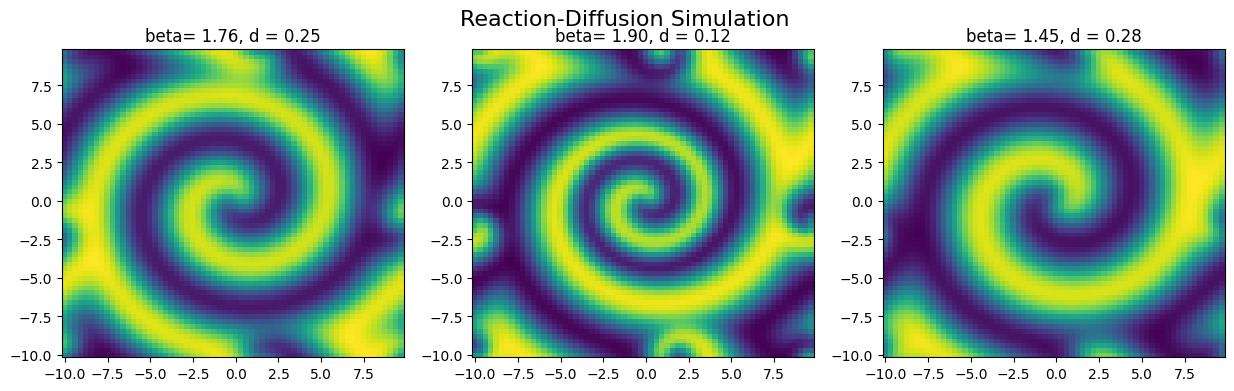

In [2]:
if load_data:
    print("Load data")
    # TODO: make data path relative and upload data to the repo
    # Read inputs
    input_path = '/Users/pconti/Desktop/AutoEmulator/ModularCirc/TestPaolo/input_data.npy'
    X = np.load(input_path)
    n_samples, n_param = X.shape

    # Read outputs
    output_path = '/Users/pconti/Desktop/AutoEmulator/ModularCirc/TestPaolo/output_data.npy'
    y = np.load(output_path)
    y = y.reshape(n_samples, -1)

    print(f"shapes: input X: {X.shape}, output y: {y.shape}\n")

else:
    print("Run simulator")
    seed = 42
    np.random.seed(seed)

    beta = (1., 2.) # lower and upper bounds for the reaction coefficient
    d = (0.05, 0.3) # lower and upper bounds for the diffusion coefficient
    lhd = LatinHypercube([beta, d])
    n_samples = 30
    X = lhd.sample(n_samples)
    U, V = zip(*[simulate_reactiondiffusion(x) for x in tqdm(X)])
    U = np.concatenate(U)
    V = np.concatenate(V)

    # Let's consider as output the field u
    y = U.reshape(n_samples, -1)

    print(f"shapes: input X: {X.shape}, output y: {y.shape}\n")

# Retain data for testing
x_test = X[:10]
y_test = y[:10]
# Remainings are for training
X = X[10:]
y = y[10:]

# Visualize the data
plot_reactiondiffuison(X, y)


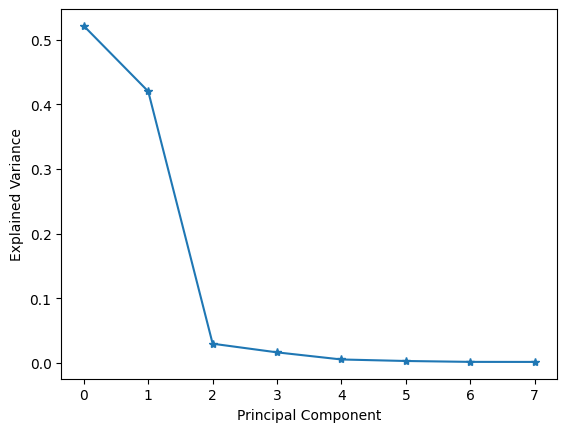

(90, 8)


In [3]:
# Perform PCA on the output data
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
y_pca = pca.fit_transform(y)

# Plot the explained variance
plt.plot(pca.explained_variance_ratio_,'*-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

print(y_pca.shape)

# Plot the PCA
#plt.scatter(y_pca[:,0], y_pca[:,1])
#plt.show()

In [4]:
## AUTOEMULATE
# inputs are standardised (scale = True)
# 5-fold cross-validation
from sklearn.model_selection import KFold

em = AutoEmulate()
em.setup(X, y, reduce_dim_output=True, dim_reducer_output=PCA(n_components=8), models=['gp'])#,  cross_validator=kfold)
best_model = em.compare()

,Values
Simulation input shape (X),"(90, 2)"
Simulation output shape (y),"(90, 4096)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),True
Dimensionality output reduction method (dim_reducer_output),PCA
Cross validator (cross_validator),KFold


Initializing:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
em.summarise_cv()

,model,short,rmse,r2
0,GaussianProcess,gp,0.040441,0.992778


In [6]:
#look at each of the cv-folds for a specific model, like GP
em.summarise_cv(model='GaussianProcess')

,fold,rmse,r2
0,0,0.037008,0.994919
1,1,0.030351,0.995979
2,2,0.044235,0.993048
3,3,0.026010,0.996467
4,4,0.064603,0.983476


Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.
Plotting the output variable with index 2. 
To plot other outputs, set `output_index` argument to the desired index.


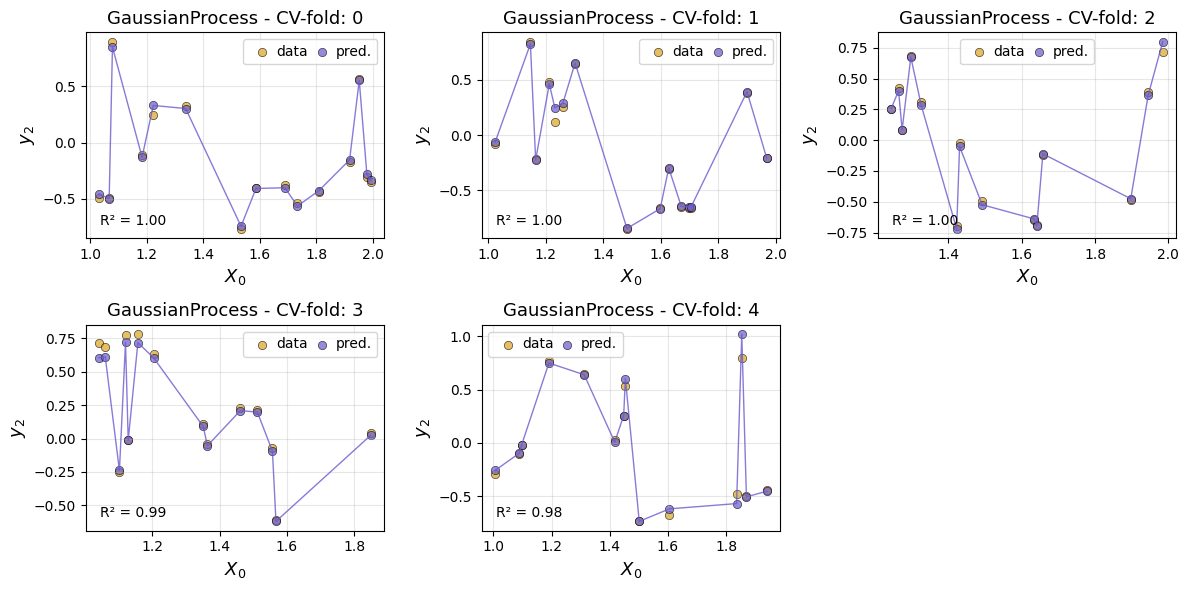

In [7]:
# To inspect spceific models more closely, we can plot the predictions for each cv fold for a given model

# Performance in predicting the first PCA component wrt first parameter (reaction beta)
PCA_component = 0
em.plot_cv(model='GaussianProcess', input_index=0, output_index=PCA_component)

# Performance in predicting the third PCA component wrt first parameter (reaction beta)
PCA_component = 2
em.plot_cv(model='GaussianProcess', input_index=0, output_index=PCA_component)


Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.


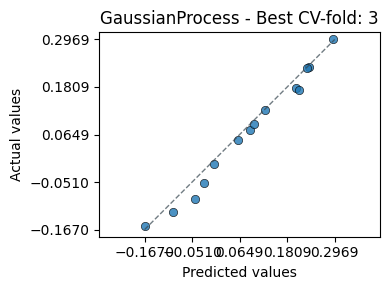

In [8]:
em.plot_cv(style="actual_vs_predicted")

Plotting the output variable with index 0. 
To plot other outputs, set `output_index` argument to the desired index.


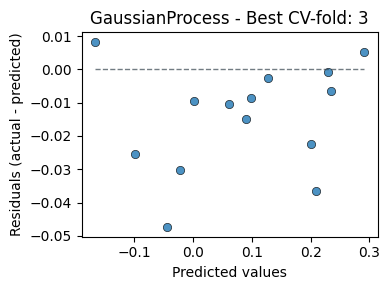

In [9]:
#Inspect the residuals too to spot any patterns
em.plot_cv(style="residual_vs_predicted")

In [10]:
## 3) Evaluate the emulator (on the test set)
gp = em.get_model('GaussianProcess')
em.evaluate(gp)

,model,short,rmse,r2
0,GaussianProcess,gp,0.0259,0.9961


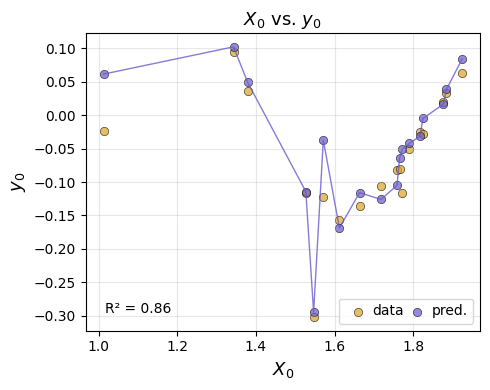

In [11]:
em.plot_eval(gp, input_index=0, output_index=0)

In [12]:
## 4) Refit the emulator model on the full data
gp_final = em.refit(gp)

## Prediction on the test set

In [13]:
# Predict on the test set
#y_pred_pca = gp_final.predict(x_test)
y_pred = gp_final.predict(x_test)

# Reconstruction of the original data
#y_pred = pca.inverse_transform(y_pred_pca)

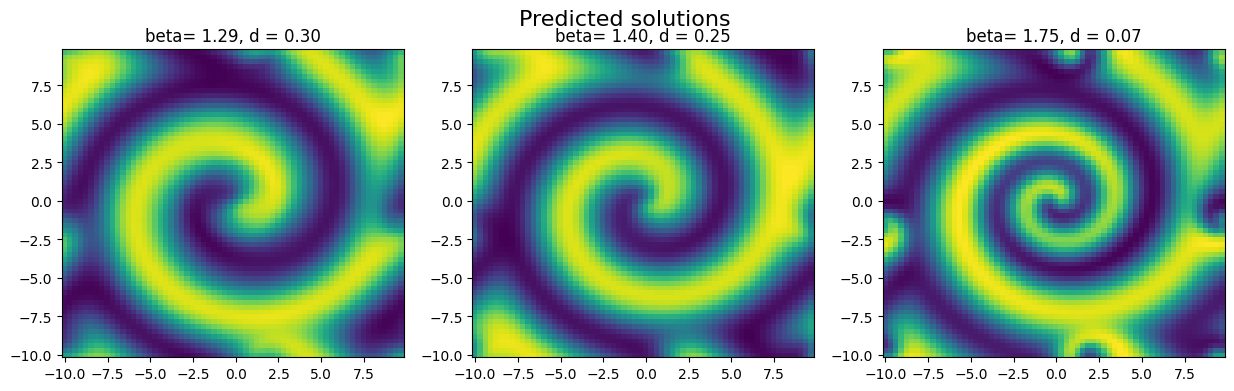

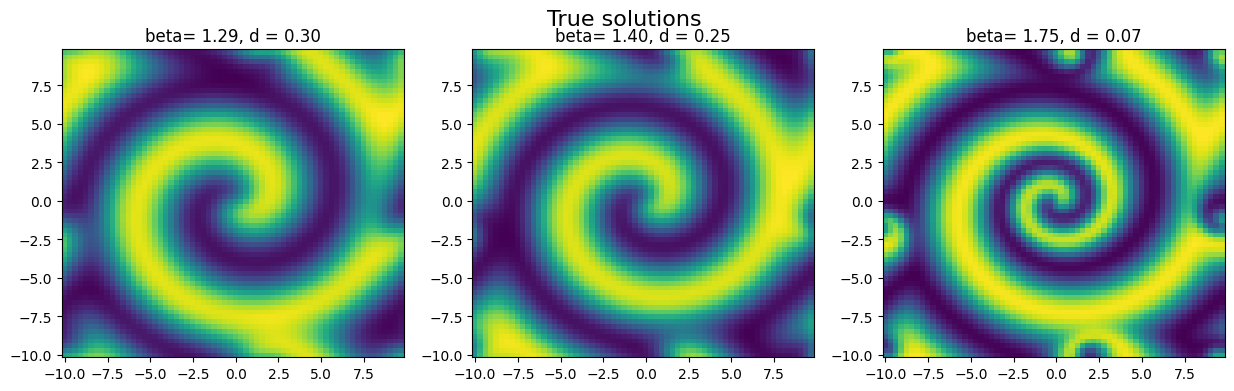

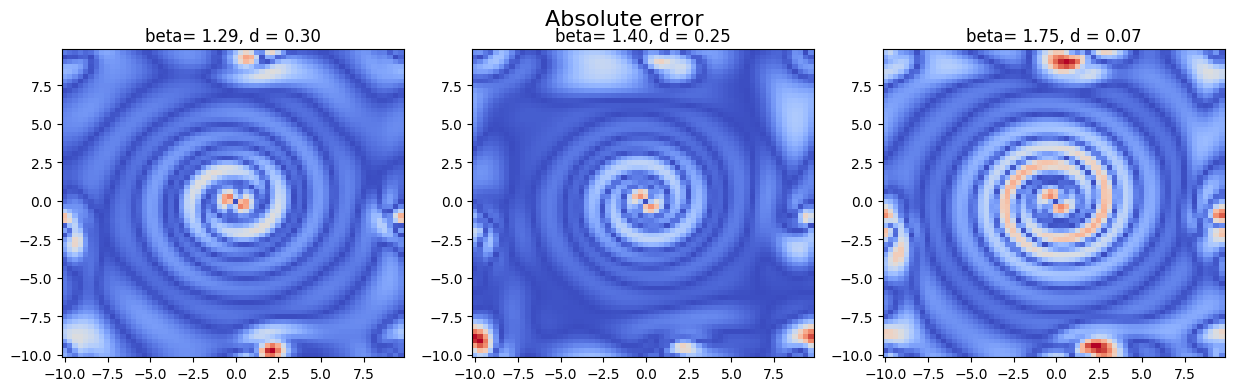

In [14]:
# Plot the predicted and true solutions
plot_reactiondiffuison(x_test, y_pred, title='Predicted solutions')
plot_reactiondiffuison(x_test, y_test, title='True solutions')

# Plot the absolute error
plot_reactiondiffuison(x_test, np.abs(y_pred - y_test), title='Absolute error', cmap='coolwarm')